# **Import and preprocessing**

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import math
from itertools import product
import numpy as np

In [41]:
#Import dataset and set sort ascending index "Date"
df = pd.read_csv("/content/NKG Historical Data.csv", parse_dates=['Date'], index_col='Date', sep=';')
df = df.sort_index(ascending=True)
print(df.head())

            Price   Open   High    Low     Vol. Change %
Date                                                    
2019-03-01  5.059  5.046  5.125  5.040  767.69K    0,00%
2019-03-04  5.224  5.257  5.289  5.125    1.92M    3,25%
2019-03-05  5.224  5.329  5.388  5.224    2.48M    0,00%
2019-03-06  5.119  5.224  5.257  5.119  697.98K   -2,01%
2019-03-07  4.935  5.217  5.217  4.935    1.29M   -3,59%


In [42]:
#Read type of dataset
print(df.dtypes)

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [43]:
#Preprocessing dataset - Change % and Vol.
df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('M', '').replace('K', '')) * (1e6 if 'M' in x else 1e3))

df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.replace(',', '.').astype(float) / 100
df.dropna(inplace=True)

print(df.dtypes)
df.head()

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,5.059,5.046,5.125,5.040,767690.0,0.0000
2019-03-04,5.224,5.257,5.289,5.125,1920000.0,0.0325
2019-03-05,5.224,5.329,5.388,5.224,2480000.0,0.0000
2019-03-06,5.119,5.224,5.257,5.119,697980.0,-0.0201
2019-03-07,4.935,5.217,5.217,4.935,1290000.0,-0.0359


Ma trận tương quan:
             Price      Open      High       Low      Vol.  Change %
Price     1.000000  0.998567  0.999363  0.999341  0.585320  0.012611
Open      0.998567  1.000000  0.999468  0.999450  0.582458 -0.027950
High      0.999363  0.999468  1.000000  0.999389  0.588668 -0.011739
Low       0.999341  0.999450  0.999389  1.000000  0.578940 -0.010647
Vol.      0.585320  0.582458  0.588668  0.578940  1.000000  0.088123
Change %  0.012611 -0.027950 -0.011739 -0.010647  0.088123  1.000000


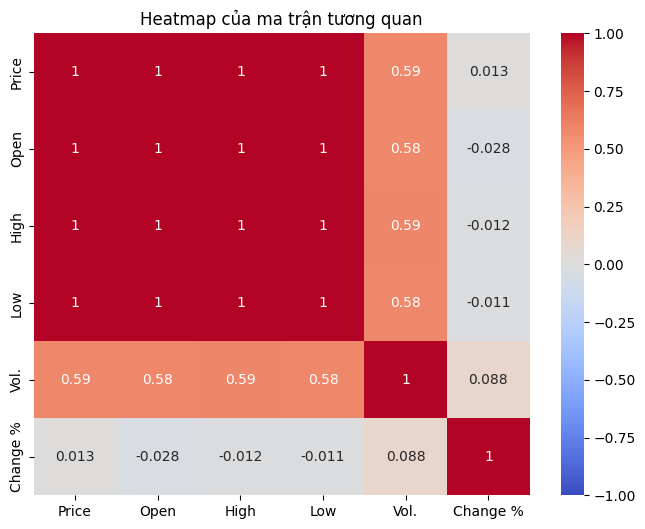

In [44]:
#Find best features for VARMA model by evaluate each features using heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(df)

corr_matrix = data.corr()

print("Ma trận tương quan:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap của ma trận tương quan')
plt.show()

In [45]:
#Choose best features from heatmap
df = df[["Price", "Open", "High", "Low"]]
df.head()

,Price,Open,High,Low
Date,,,,
2019-03-01,5.059,5.046,5.125,5.040
2019-03-04,5.224,5.257,5.289,5.125
2019-03-05,5.224,5.329,5.388,5.224
2019-03-06,5.119,5.224,5.257,5.119
2019-03-07,4.935,5.217,5.217,4.935


# **Split train, test by 90:10**

In [46]:
#Split train and test by 9:1
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1252
1126
126


In [47]:
#Find best AR and MA for VARMA modeling by evalute AIC.
p_values = range(1, 5)
q_values = range(1, 5)

best_aic = np.inf
best_order = (0, 0)

for p in p_values:
    for q in q_values:
        try:
            model = VARMAX(data, order=(p, q))
            model_fit = model.fit(disp=False)

            aic = model_fit.aic

            print(f'VARMA({p}, {q}) - AIC: {aic}')

            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except Exception as e:
            print(f'VARMA({p}, {q}) - Error: {e}')

print(f'Best VARMA order: {best_order} - AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.14548e-29): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.61174e-27): result may not be accurate.
  x = solve(lhs, q.flatten())


VARMA(1, 1) - AIC: 35205.27067977525


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.14548e-29): result may not be accurate.
  x = solve(lhs, q.flatten())


VARMA(1, 2) - Error: Schur decomposition solver error.
VARMA(1, 3) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.14548e-29): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10

VARMA(1, 4) - Error: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.11336e-25): result may not be accurate.
  x = solve(lhs, q.flatten())


VARMA(2, 1) - Error: Schur decomposition solver error.
VARMA(2, 2) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

VARMA(2, 3) - Error: Schur decomposition solver error.
VARMA(2, 4) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

VARMA(3, 1) - AIC: 34909.64986027128


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA(3, 2) - AIC: 35768.47489264878


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA(3, 3) - AIC: 447110116.191594


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VARMA(3, 4) - Error: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32689e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


KeyboardInterrupt: 

In [48]:
#Create model and training
model = VARMAX(train, order=(4, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                 1126
Model:                           VARMA(4,1)   Log Likelihood                -373.117
                                + intercept   AIC                            934.235
Date:                      Sun, 09 Jun 2024   BIC                           1406.719
Time:                              13:08:01   HQIC                          1112.774
Sample:                                   0                                         
                                     - 1126                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):         0.00, 0.00, 0.00, 0.00   Jarque-Bera (JB):   433.91, 2765.27, 3645.09, 1231.00
Prob(Q):                    0.99, 0.97, 0.99, 0.99   Prob(JB):                      0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H

In [49]:
#Forecast test dataset
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                Price       Open       High        Low
Date                                                  
2023-08-29  18.645658  18.699470  18.991873  18.387858
2023-08-30  18.721053  18.710118  19.058956  18.375999
2023-08-31  18.795602  18.772337  19.145737  18.435800
2023-09-05  18.862372  18.845972  19.226470  18.483917
2023-09-06  18.891154  18.898279  19.283781  18.521352


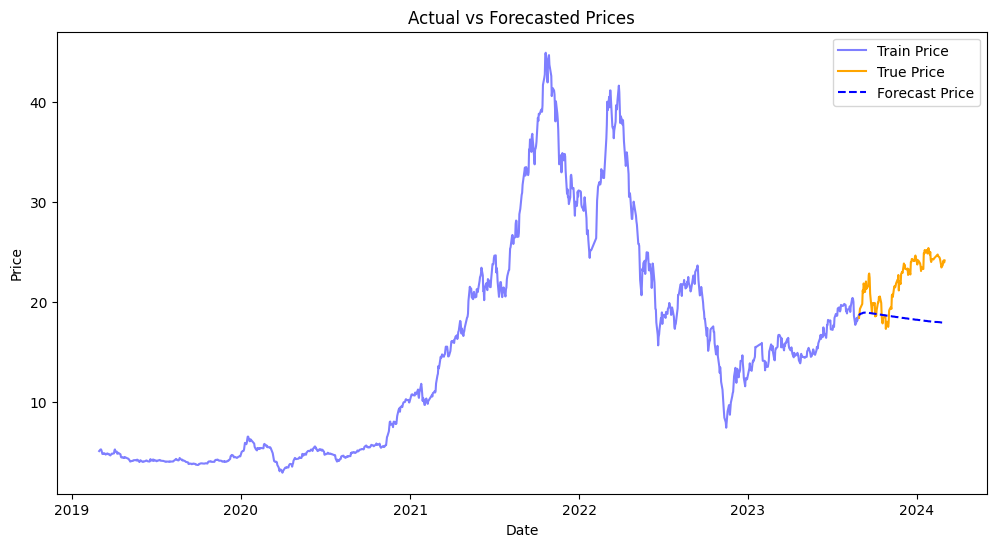

In [50]:
#Visualize result into plt for better understading
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)

plt.plot(test.index, test["Price"], label='True Price', color='orange')

plt.plot(test.index, forecast["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**MAE, MAPE, RMSE**

In [51]:
#Determine MEAN and MAPE, RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

mae = mean_absolute_error(test["Price"], forecast["Price"])
mape = mean_absolute_percentage_error(test["Price"], forecast["Price"])
rmse = np.sqrt(mean_squared_error(test["Price"], forecast["Price"]))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 3.756898379828039
Mean Absolute Percentage Error (MAPE): 0.16091631982316157
Root Mean Squared Error (RMSE): 4.424748053603655


# **Forecast next 30,60,90 days**

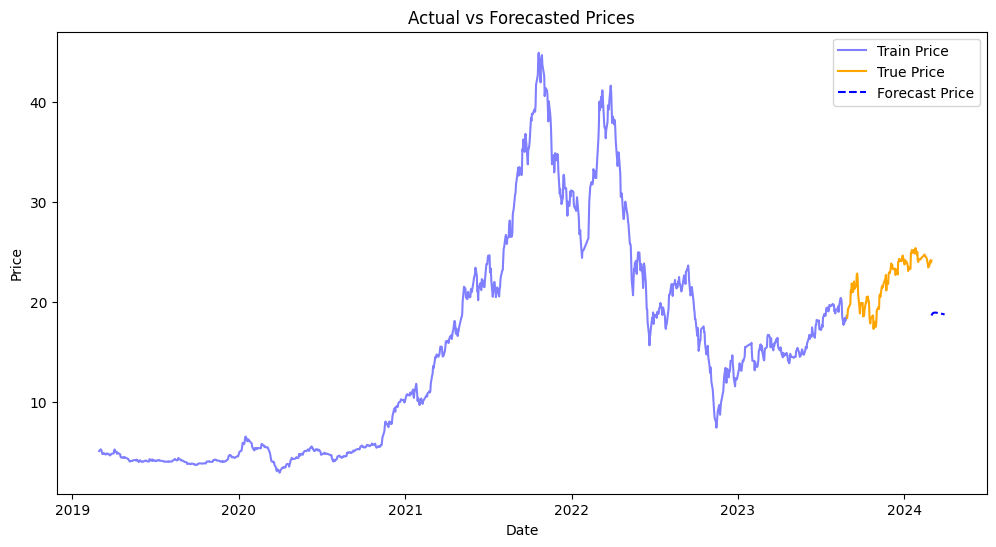

In [52]:
forecast_horizon = 30
next_30_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_30_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


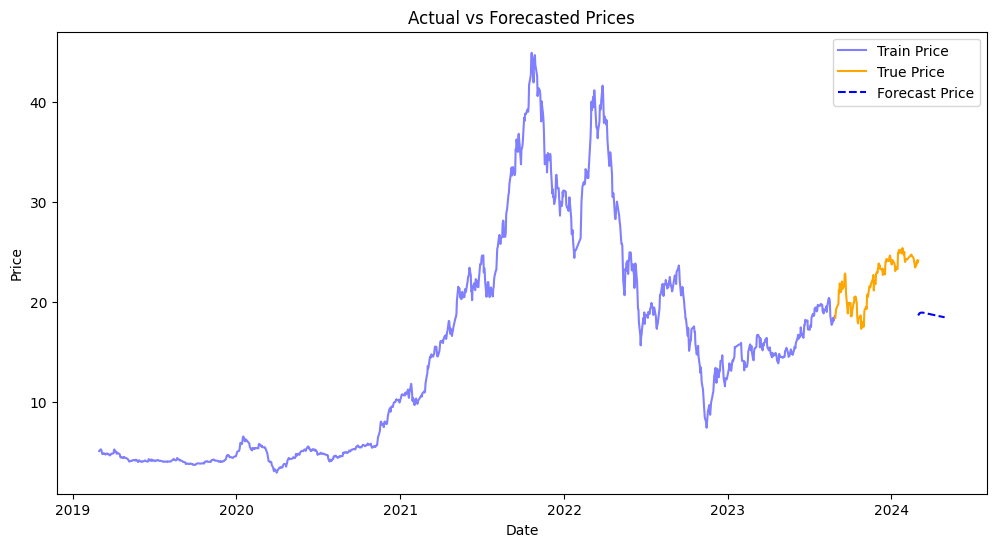

In [53]:
forecast_horizon = 60
next_60_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_60_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

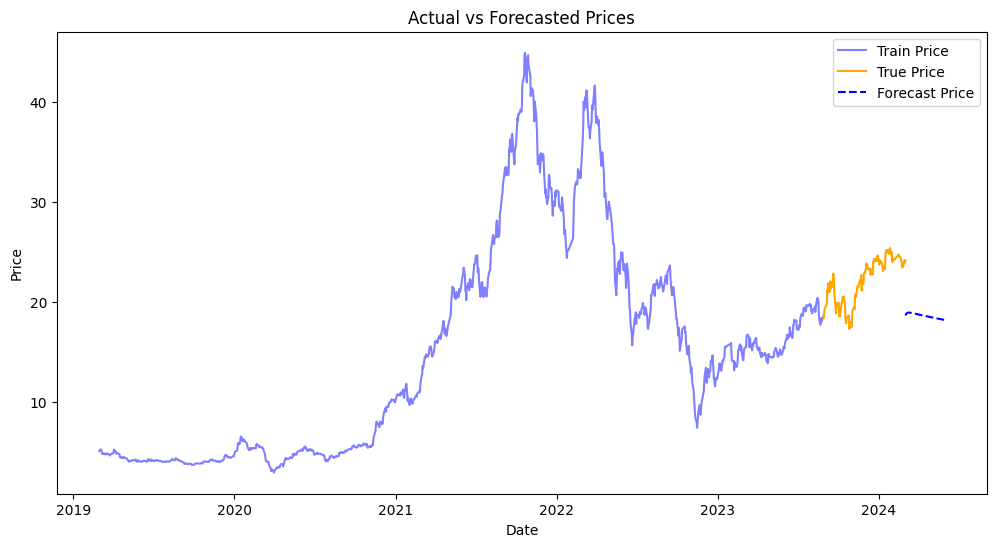

In [54]:
forecast_horizon = 90
next_90_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_90_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()